<a href="https://colab.research.google.com/github/Karthika-Arumugam/CMPE256-Final-Project/blob/master/covid_forecast_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the neccessary libraries

In [0]:
pip install bubbly

  Created wheel for bubbly: filename=bubbly-1.0.2-cp36-none-any.whl size=5428 sha256=050494a20e16c8fb9006b19cc35d6abcba857f8212aad3cee14687b2dfb3dd5a
  Stored in directory: /root/.cache/pip/wheels/cf/3c/75/8c09dbf7cd6b320b69a6bc679fd111abd1139866c722b1476b
Successfully built bubbly


In [0]:
pip install chart_studio

     |████████████████████████████████| 71kB 5.0MB/s 


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from bubbly.bubbly import bubbleplot 
from plotly.offline import iplot
import chart_studio.plotly as py
plt.style.use('fivethirtyeight')

# **Dataset and Data Preprocessing**



In [0]:
covid_df= pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",index_col=[0], parse_dates=[0])

In [0]:
covid_df.shape

(86952, 5)

In [0]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86952 entries, 2020-01-21 to 2020-04-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   county  86952 non-null  object 
 1   state   86952 non-null  object 
 2   fips    85882 non-null  float64
 3   cases   86952 non-null  int64  
 4   deaths  86952 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [0]:
covid_df= covid_df.drop(['fips'], axis=1)

In [0]:
 covid_df.head()

,county,state,cases,deaths
date,,,,
2020-01-21,Snohomish,Washington,1,0
2020-01-22,Snohomish,Washington,1,0
2020-01-23,Snohomish,Washington,1,0
2020-01-24,Cook,Illinois,1,0
2020-01-24,Snohomish,Washington,1,0


In [0]:
covid_df.describe()

,cases,deaths
count,86952.000000,86952.000000
mean,167.740098,6.849446
std,2027.119452,127.391531
min,0.000000,0.000000
25%,2.000000,0.000000
50%,8.000000,0.000000
75%,35.000000,1.000000
max,150484.000000,11157.000000


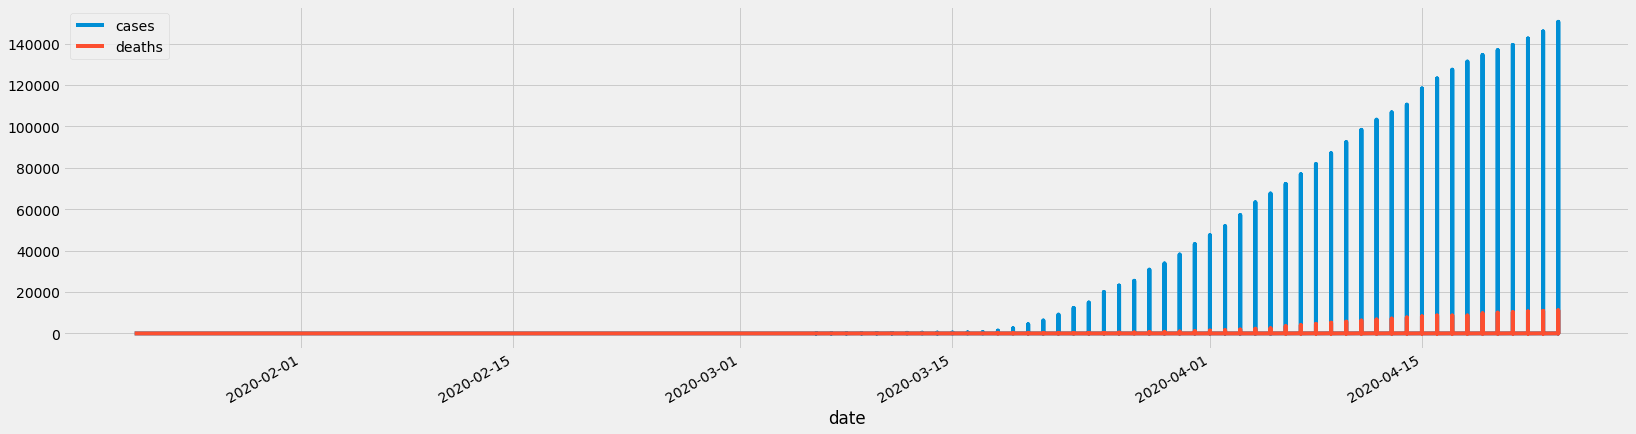

In [0]:
covid_df.plot(kind='line',figsize=(25,7))
plt.show()

In [0]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# **PREDICTION**
**Covid-19 Spread US - County Wise Forecast Prediction with FBPROPHET MODEL**

TRAIN TEST SPLIT 

In [0]:
def fbprophet_fit_train_predict(train, test):
  print(bcolors.BOLD+"Formatting data for fbprophet model")
  print(bcolors.ENDC)
  print(train.reset_index() \
    .rename(columns={'date':'ds',
                     'Confirmed':'y'}).head())
  model = Prophet()
  model.add_seasonality(name="monthly",period=30.5,fourier_order=7)
  model.fit(train.reset_index() \
              .rename(columns={'date':'ds',
                               'Confirmed':'y'}))
  test_fcst = model.predict(df=test.reset_index() \
                                  .rename(columns={'date':'ds'}))
  print(bcolors.BOLD+"Test Set Prediction Values and thresholds")
  print(bcolors.ENDC)
  print(test_fcst.head())
  print()
  print(bcolors.BOLD+"Test Set Prediction Trend")
  print(bcolors.ENDC)
  f, ax = plt.subplots(1)
  f.set_figheight(5)
  f.set_figwidth(15)
  fig = model.plot(test_fcst,
                 ax=ax)
  plt.show()
  print()
  print(bcolors.BOLD+"Test Set components Trend")
  print(bcolors.ENDC)
  fig = model.plot_components(test_fcst)
  plt.show()
  future_dates = model.make_future_dataframe(periods=30)
  prediction =  model.predict(future_dates)
  print(bcolors.BOLD+"Forecast for next two weeks")
  print(bcolors.ENDC)
  fig = model.plot(prediction)
  c = add_changepoints_to_plot(fig.gca(),model,prediction)
  plt.show()

In [0]:
def train_test_split(df, split_date):
  t = split_date.strftime('%Y-%m-%d')
  train = df.loc[df.index <= t].copy()
  test = df.loc[df.index > t].copy()
  print(bcolors.BOLD+"Train Data Description")
  print(bcolors.ENDC)
  print(train.describe())
  print()
  print(bcolors.BOLD + 'Train Test Split Trend' )
  test \
    .rename(columns={'Confirmed': 'TEST SET'}) \
    .join(train.rename(columns={'Confirmed': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(30,7), title='Train Test Split')
  plt.show()
  fbprophet_fit_train_predict(train, test)

In [0]:
def findSplitPoint(df):
  print("first row date", df.index[0])
  start_date = (df.index[0]).date()
  cur_date = date.today()
  tol_days= cur_date - start_date
  print("total days", tol_days)
  days = tol_days*.2
  split_date=cur_date - days
  print("split_date",split_date)
  return split_date

**CROSS VALIDATION USING PROBHET'S DIAGNOSTICS**

In [0]:
def cross_validate(df):
  fig, ax = plt.subplots(10,1, figsize = (14, 20))
  ax = ax.ravel()
  df=df.reset_index()
  df=df.rename(columns={'date':'ds','Confirmed':'y'})
  j = 0
  for i in [0.01, 0.05, 0.10, 0.15, 0.20]:
    m = Prophet(changepoint_prior_scale=i)
    #fit the prophet model on the data
    m.fit(df)
    # make a dataframe of the next 20 days 
    future = m.make_future_dataframe(periods=20)
    #predict on this future dataframe
    forecast = m.predict(future)
    # plot the forecast 
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='30 days', period='5 days', horizon = '10 days')
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,0.5)
    j += 1
  plt.show()
  df_p = performance_metrics(df_cv)
  print(bcolors.BOLD+"Performance and Error Metrics")
  print(bcolors.ENDC)
  print(df_p.head())

In [0]:
def predictSpread(State, County):
  county_df = covid_df[(covid_df['state'] == State) & (covid_df['county'] == County)]
  county_df=county_df.drop(['county', 'state'], axis=1)
  county_df.columns = ['Confirmed', 'Deaths']
  print(bcolors.BOLD+"Data Description")
  print(bcolors.ENDC)
  print(county_df.head())
  print()
  print(bcolors.BOLD+" Current Spread Trend in the", County , "county, ",State)
  plt.figure(figsize=(23,10))
  plt.bar(county_df.index, county_df.Confirmed,label="Confirm Cases")
  plt.bar(county_df.index, county_df.Deaths,label="Deaths")
  plt.xlabel('Date')
  plt.ylabel("Count")
  plt.legend(frameon=True, fontsize=12)
  plt.title('Confirmed vs Deaths',fontsize = 35)
  plt.show()
  county_df.plot(kind='line',figsize=(25,7))
  plt.show()
  if len(county_df.index) < 30:
    print(bcolors.OKBLUE+" Too less data to forsee the forecast or The ",County, " County is very good at Social Distancing ")
    return
  county_df=county_df.drop(['Deaths'], axis=1)
  split_date = findSplitPoint(county_df)
  train_test_split(county_df, split_date)
  cross_validate(county_df)

**ENTER STATE AND COUNTY TO SEE THE FORECAST**

Data Description

            Confirmed  Deaths
date                         
2020-01-25          1       0
2020-01-26          1       0
2020-01-27          1       0
2020-01-28          1       0
2020-01-29          1       0

 Current Spread Trend in the Orange county,  California


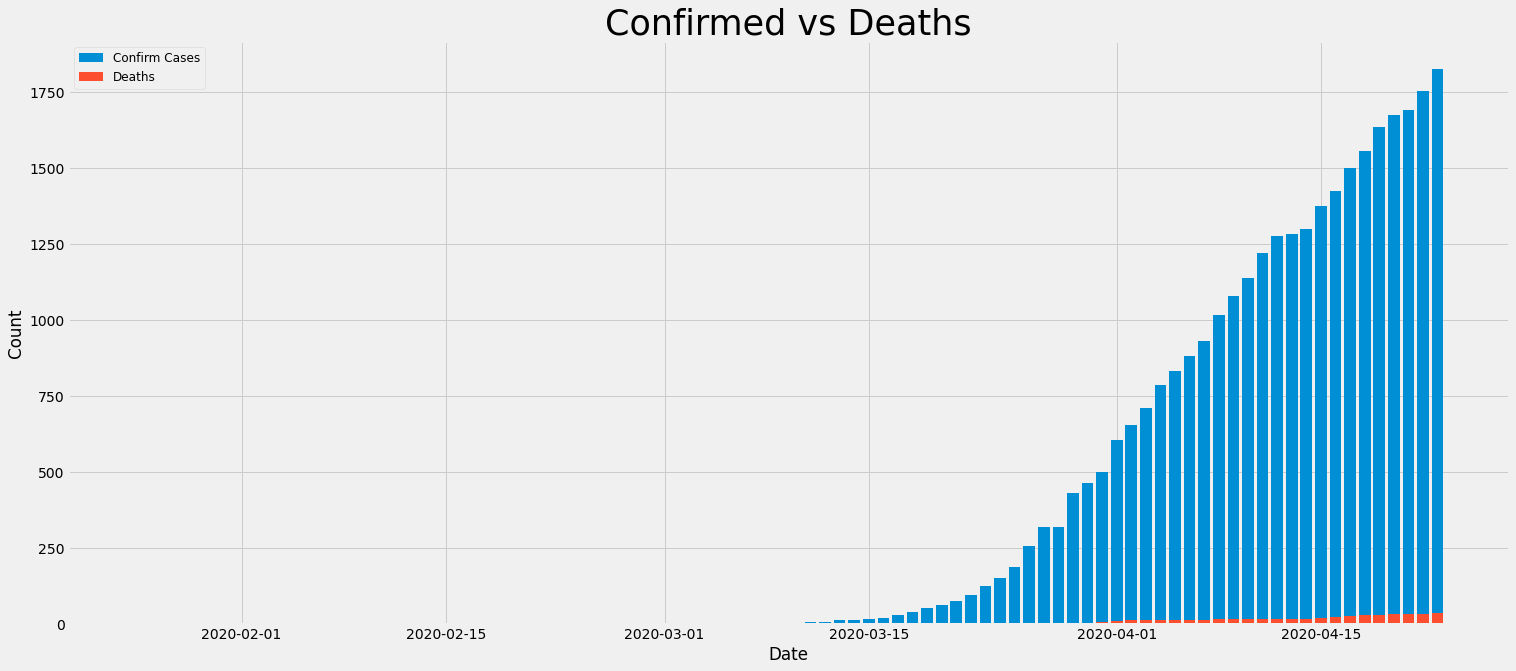

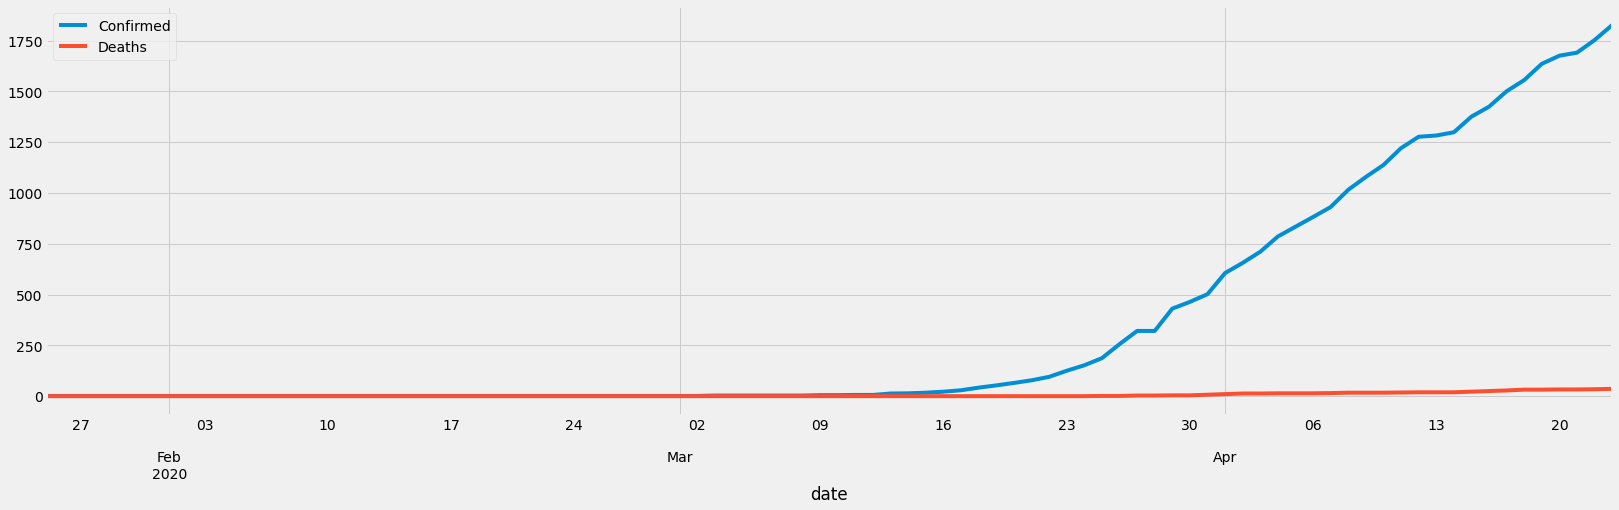

first row date 2020-01-25 00:00:00
total days 90 days, 0:00:00
split_date 2020-04-06
Train Data Description

        Confirmed
count   73.000000
mean   106.027397
std    223.550701
min      1.000000
25%      1.000000
50%      1.000000
75%     53.000000
max    882.000000

Train Test Split Trend


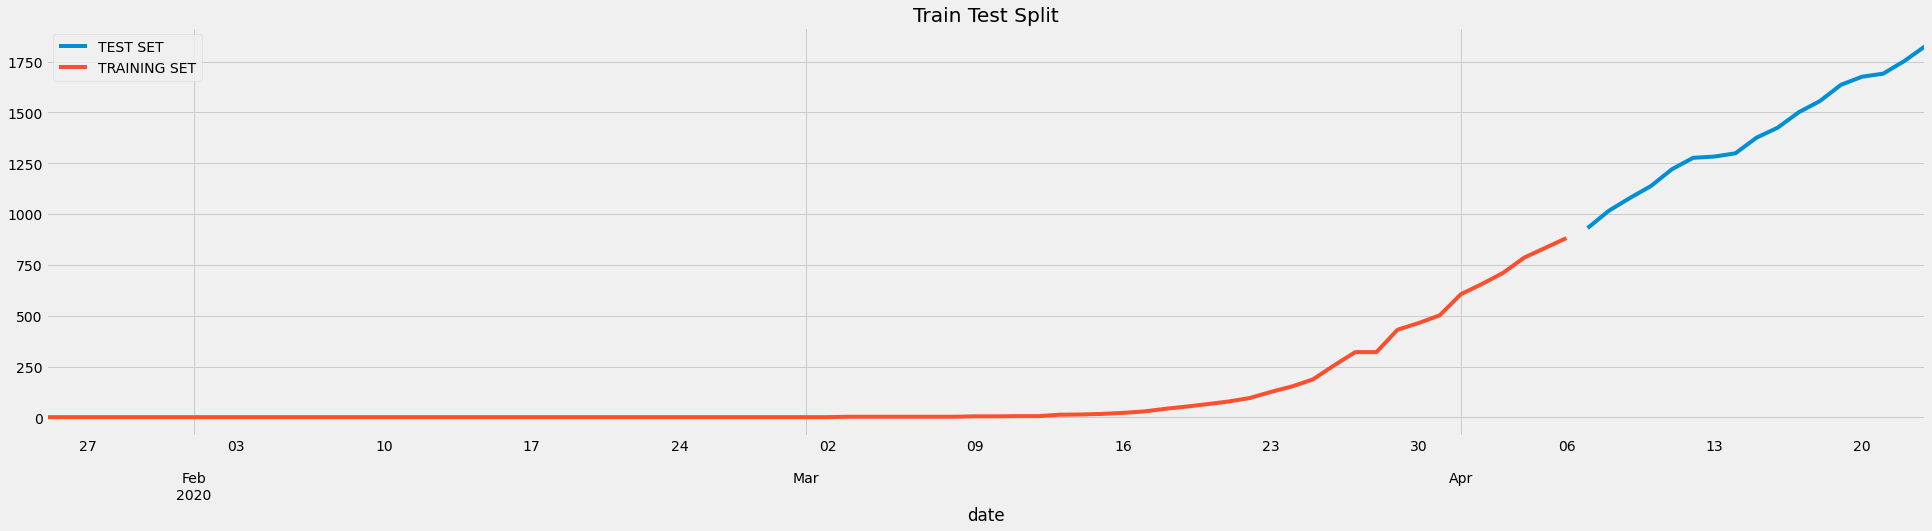

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Formatting data for fbprophet model

          ds  y
0 2020-01-25  1
1 2020-01-26  1
2 2020-01-27  1
3 2020-01-28  1
4 2020-01-29  1
Test Set Prediction Values and thresholds

          ds        trend  ...  multiplicative_terms_upper         yhat
0 2020-04-07   919.920932  ...                         0.0   914.555601
1 2020-04-08   973.897573  ...                         0.0   970.058091
2 2020-04-09  1027.874214  ...                         0.0  1024.294533
3 2020-04-10  1081.850855  ...                         0.0  1080.280278
4 2020-04-11  1135.827496  ...                         0.0  1133.443524

[5 rows x 19 columns]

Test Set Prediction Trend



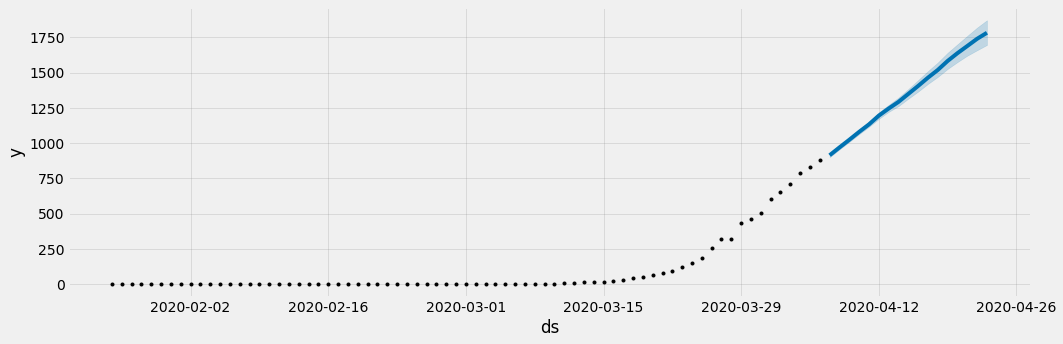


Test Set components Trend



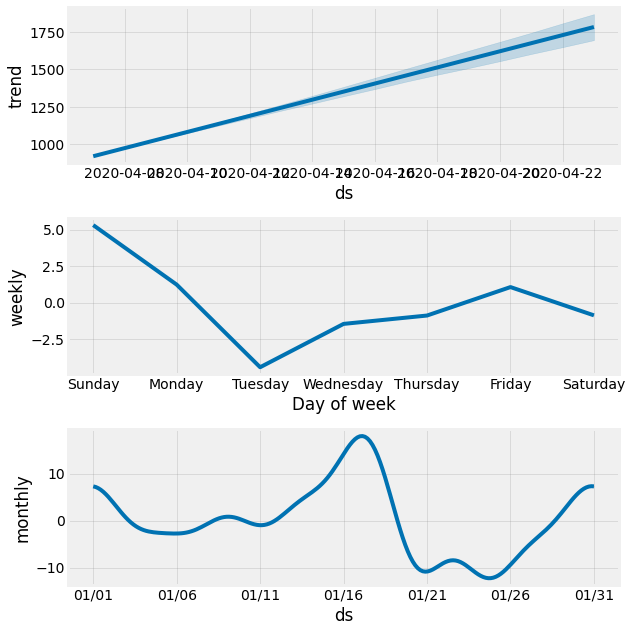

Forecast for next two weeks



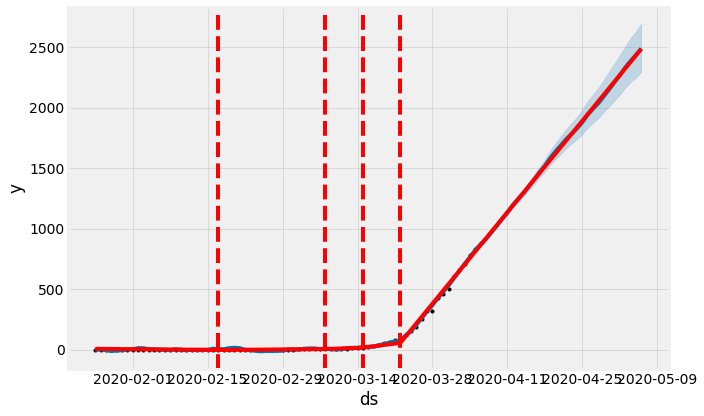

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-02-28 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-02-28 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-02-28 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=T

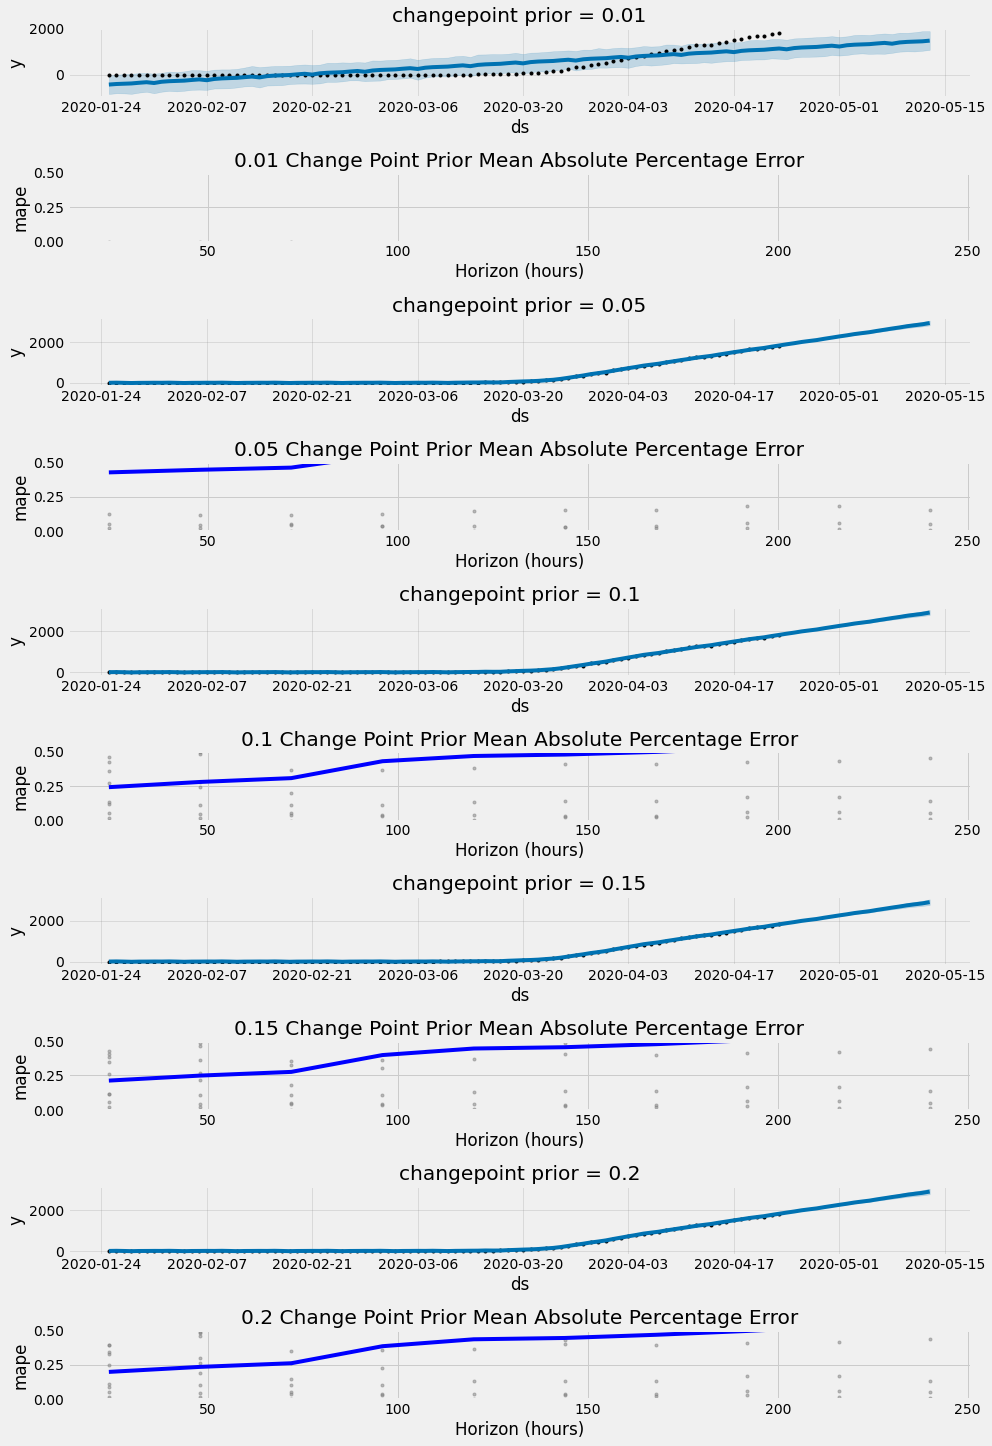

Performance and Error Metrics

  horizon           mse        rmse        mae      mape     mdape  coverage
0  1 days   3208.155540   56.640582  39.593340  0.198365  0.182624       0.1
1  2 days   4592.816967   67.770325  47.382339  0.234689  0.227240       0.1
2  3 days   9570.560670   97.829242  67.469526  0.261034  0.204749       0.1
3  4 days  10466.949001  102.308108  72.048610  0.384300  0.441682       0.0
4  5 days  17269.389606  131.413050  88.157559  0.434407  0.557156       0.1


In [0]:
predictSpread("California","Orange")

Data Description

            Confirmed  Deaths
date                         
2020-03-01          1       0
2020-03-02          1       0
2020-03-03          2       0
2020-03-04          2       0
2020-03-05          4       0

 Current Spread Trend in the New York City county,  New York


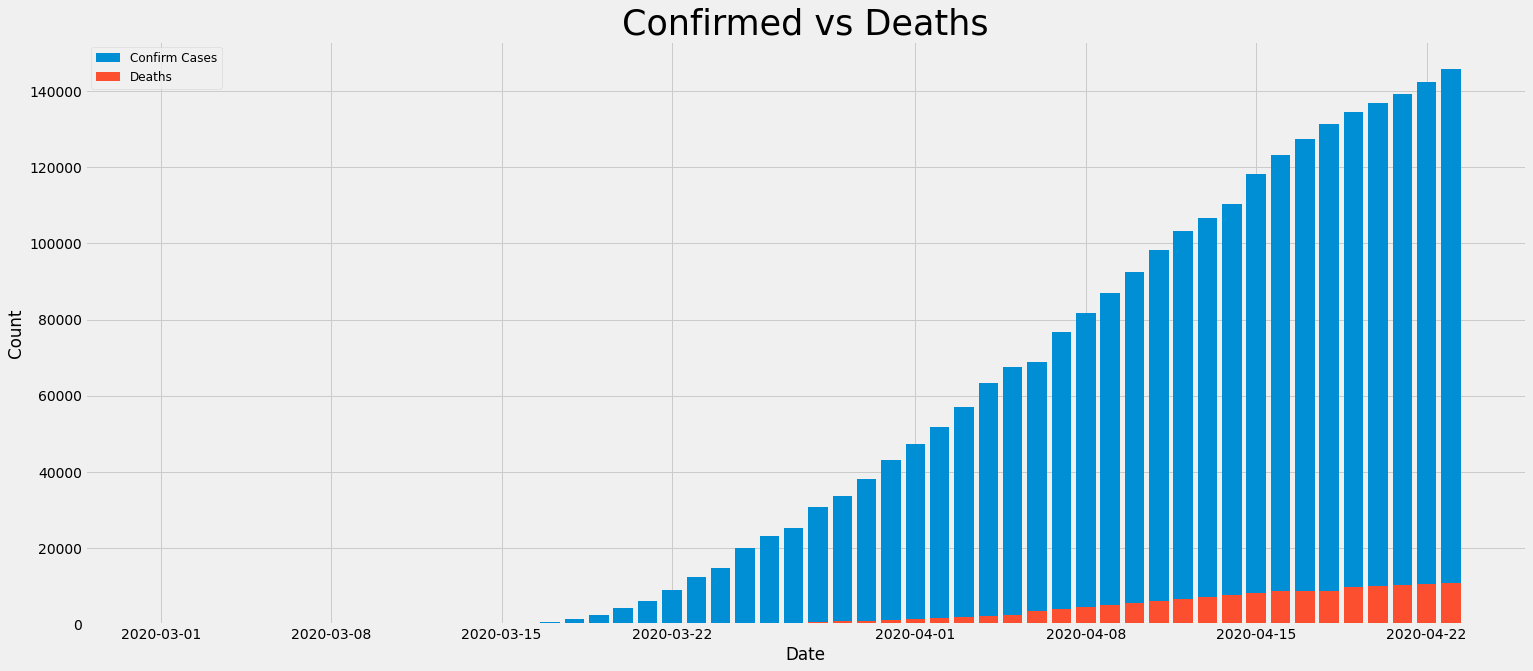

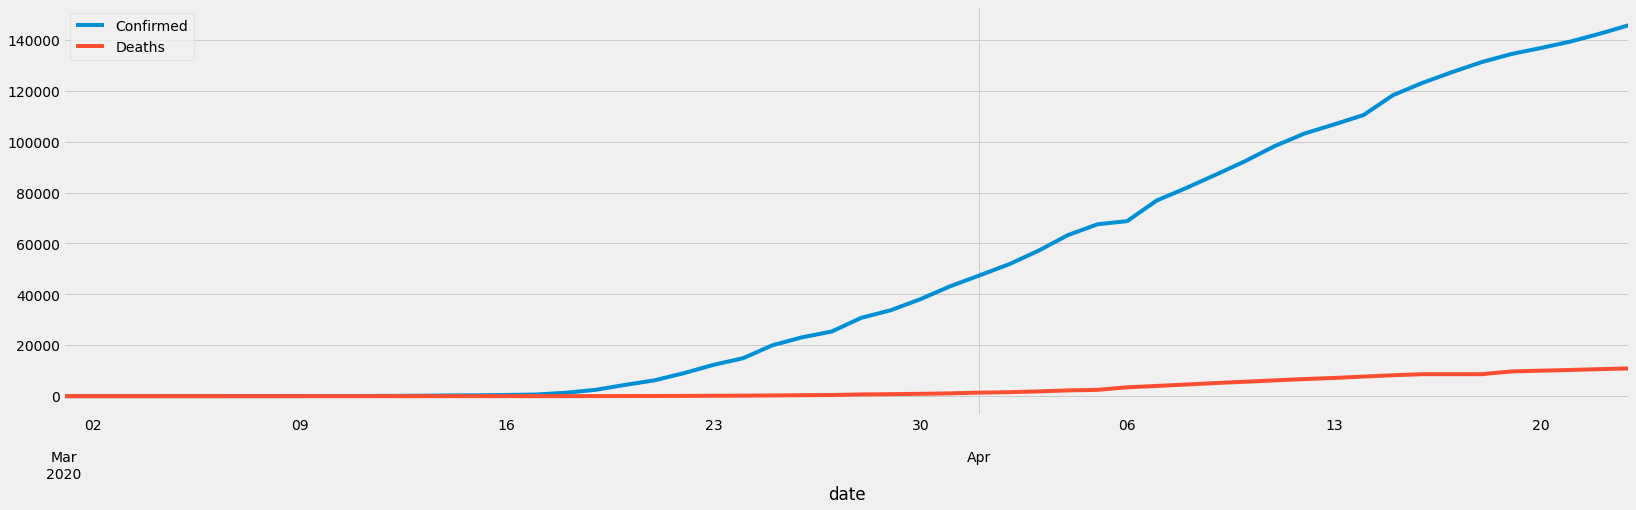

first row date 2020-03-01 00:00:00
total days 54 days, 0:00:00
split_date 2020-04-14
Train Data Description

           Confirmed
count      45.000000
mean    30665.622222
std     36715.791298
min         1.000000
25%        96.000000
50%     12305.000000
75%     57160.000000
max    110465.000000

Train Test Split Trend


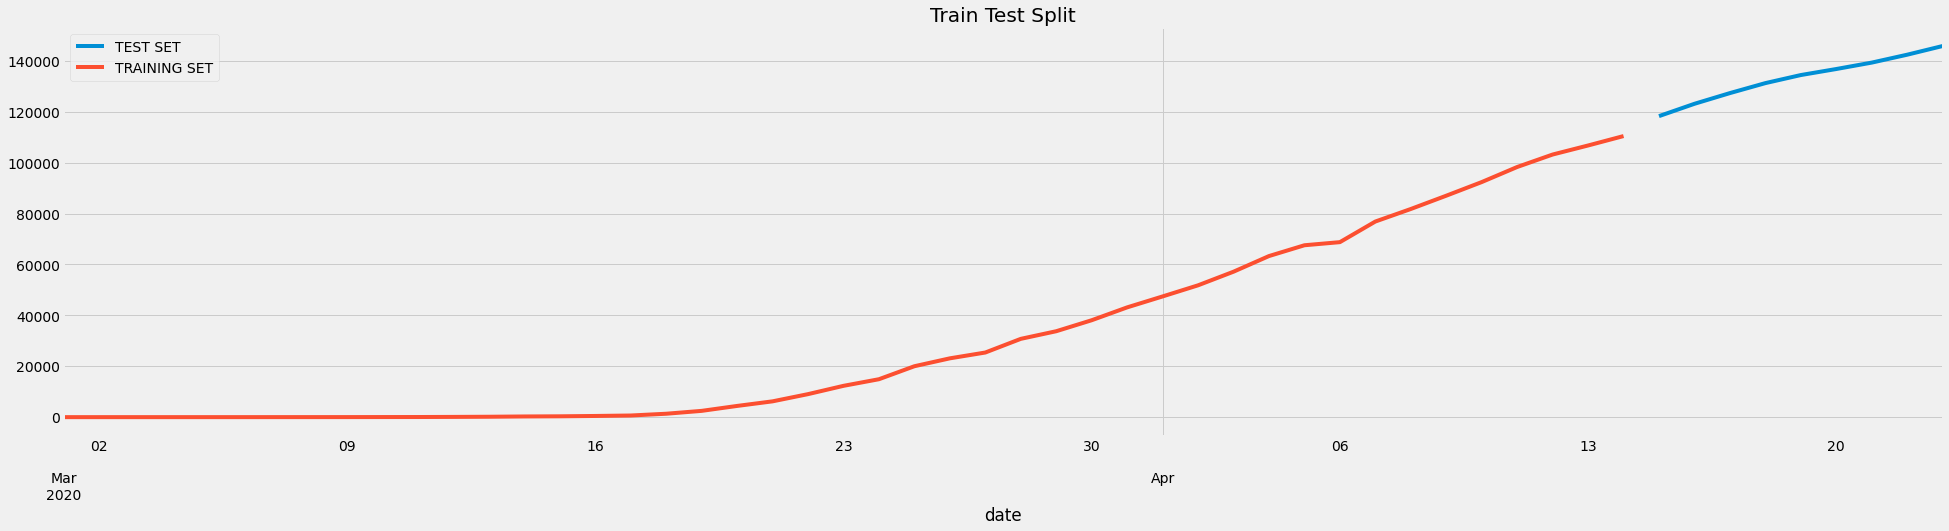

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Formatting data for fbprophet model

          ds  y
0 2020-03-01  1
1 2020-03-02  1
2 2020-03-03  2
3 2020-03-04  2
4 2020-03-05  4
Test Set Prediction Values and thresholds

          ds          trend  ...  multiplicative_terms_upper           yhat
0 2020-04-15  110349.016193  ...                         0.0  113775.951047
1 2020-04-16  114929.246029  ...                         0.0  117121.089558
2 2020-04-17  119509.475865  ...                         0.0  120643.354281
3 2020-04-18  124089.705700  ...                         0.0  124262.798825
4 2020-04-19  128669.935536  ...                         0.0  126038.491648

[5 rows x 19 columns]

Test Set Prediction Trend



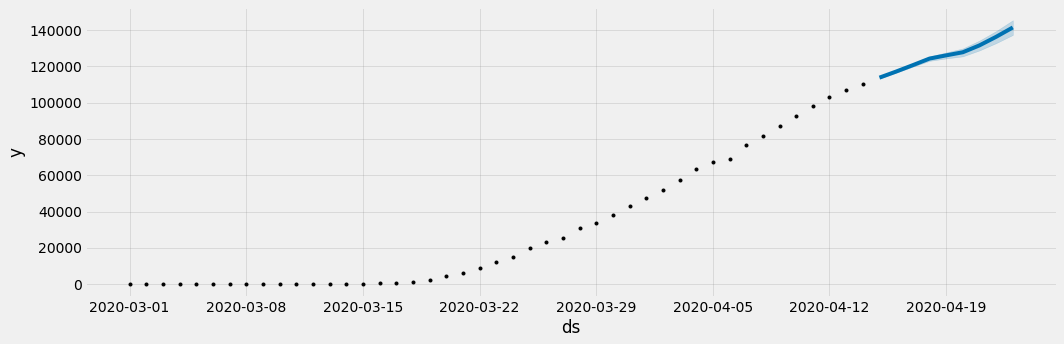


Test Set components Trend



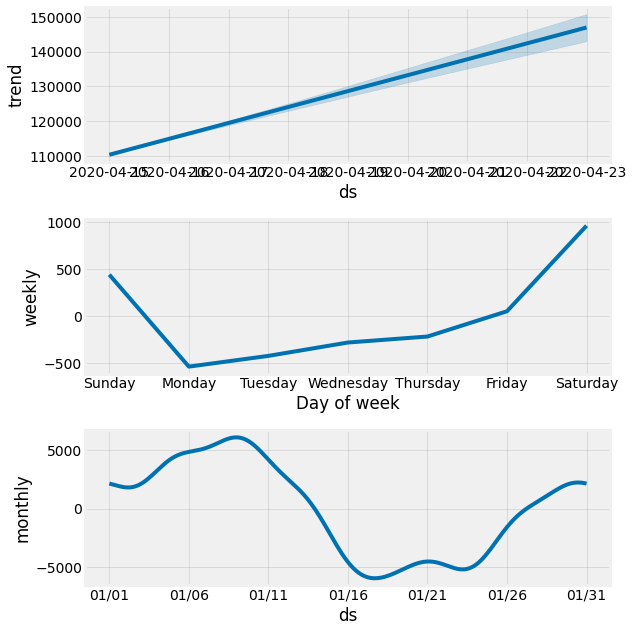

Forecast for next two weeks



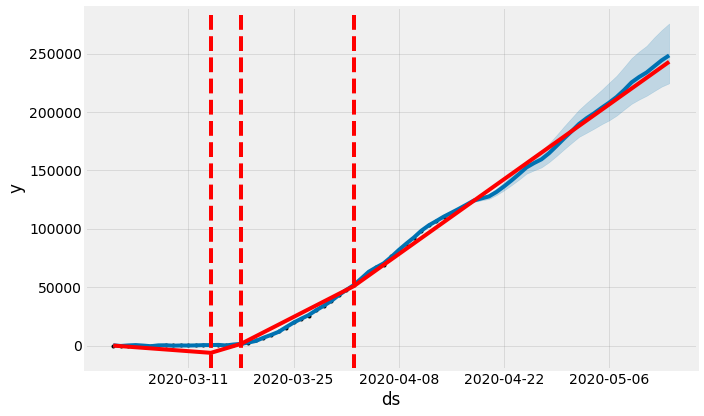

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-04-03 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-04-03 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-04-03 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True

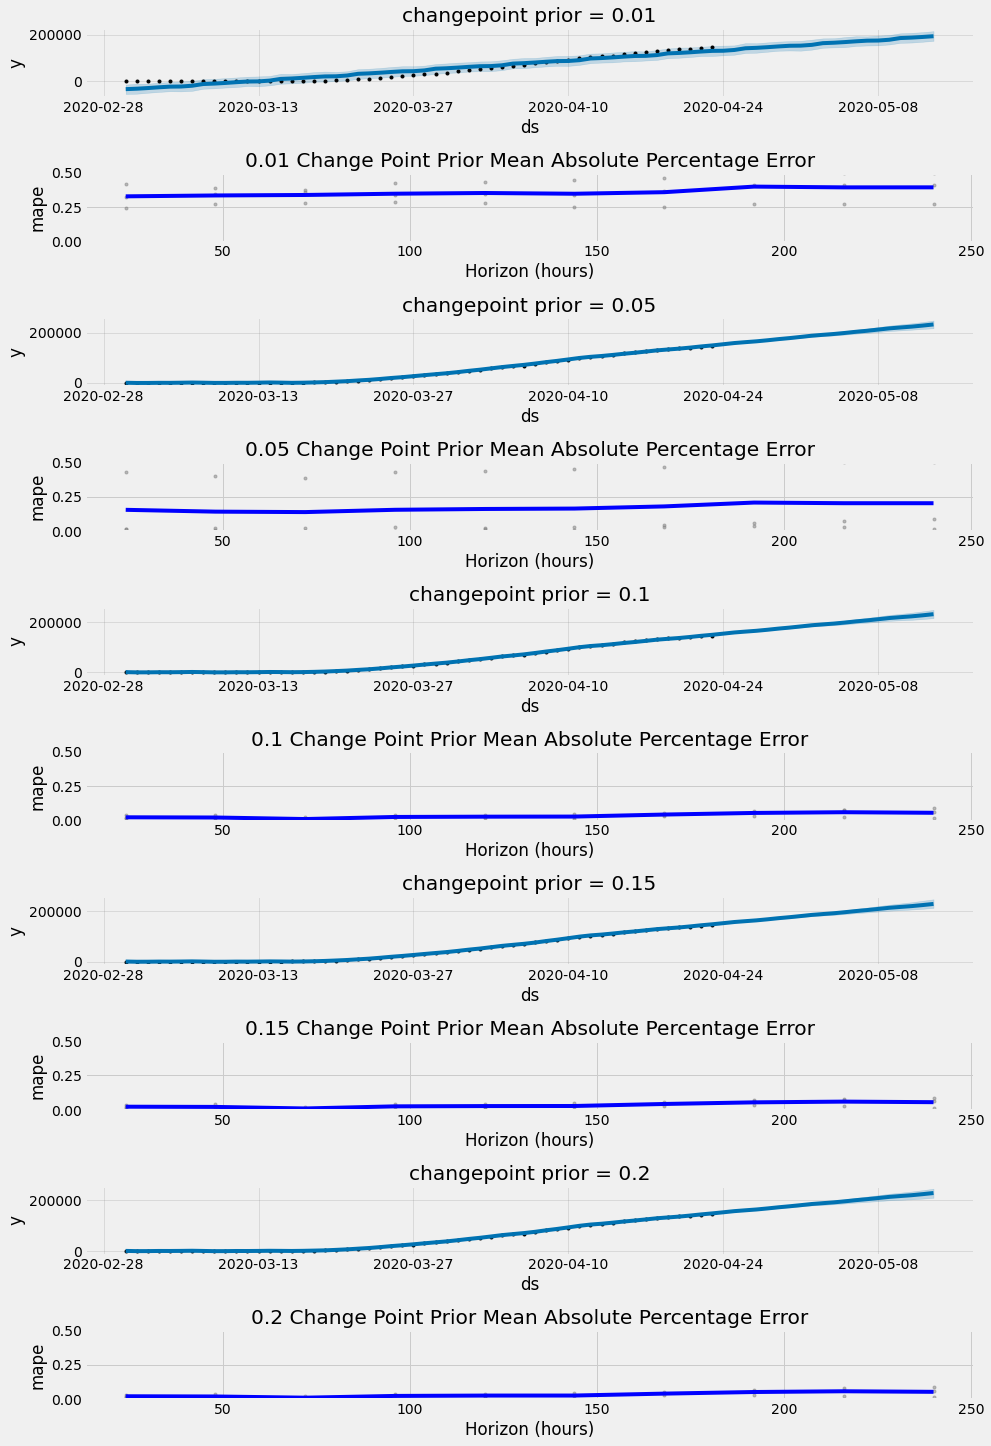

Performance and Error Metrics

  horizon           mse         rmse          mae      mape     mdape  coverage
0  1 days  3.362207e+06  1833.632235  1791.183204  0.021994  0.018200  0.000000
1  2 days  3.319214e+06  1821.871042  1612.730701  0.020406  0.020112  0.333333
2  3 days  2.024817e+06  1422.960551  1075.443386  0.011739  0.009416  0.666667
3  4 days  6.057518e+06  2461.202542  2220.990770  0.024392  0.028540  0.333333
4  5 days  7.523198e+06  2742.844889  2719.400306  0.027023  0.022154  0.000000


In [0]:
predictSpread("New York","New York City")

Data Description

            Confirmed  Deaths
date                         
2020-03-05          4       0
2020-03-06          5       0
2020-03-07          5       0
2020-03-08          6       0
2020-03-09          6       0

 Current Spread Trend in the Harris county,  Texas


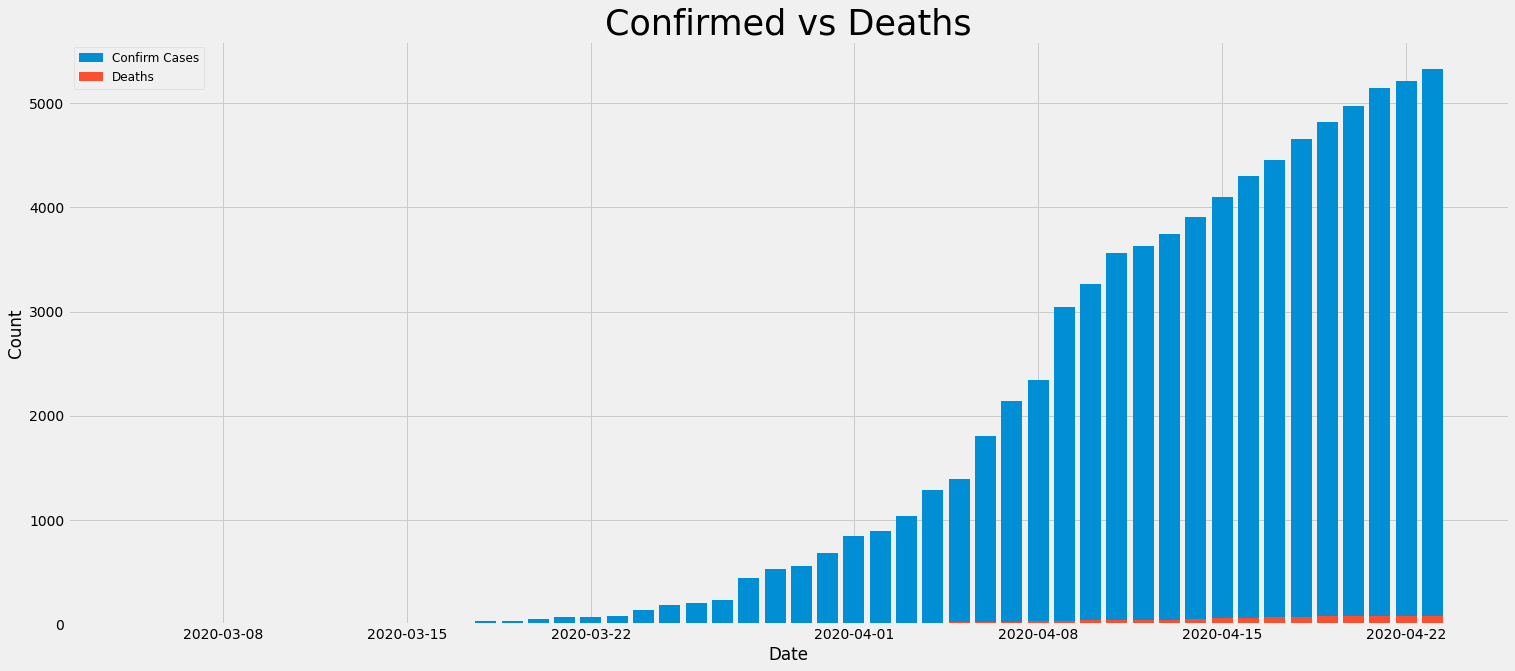

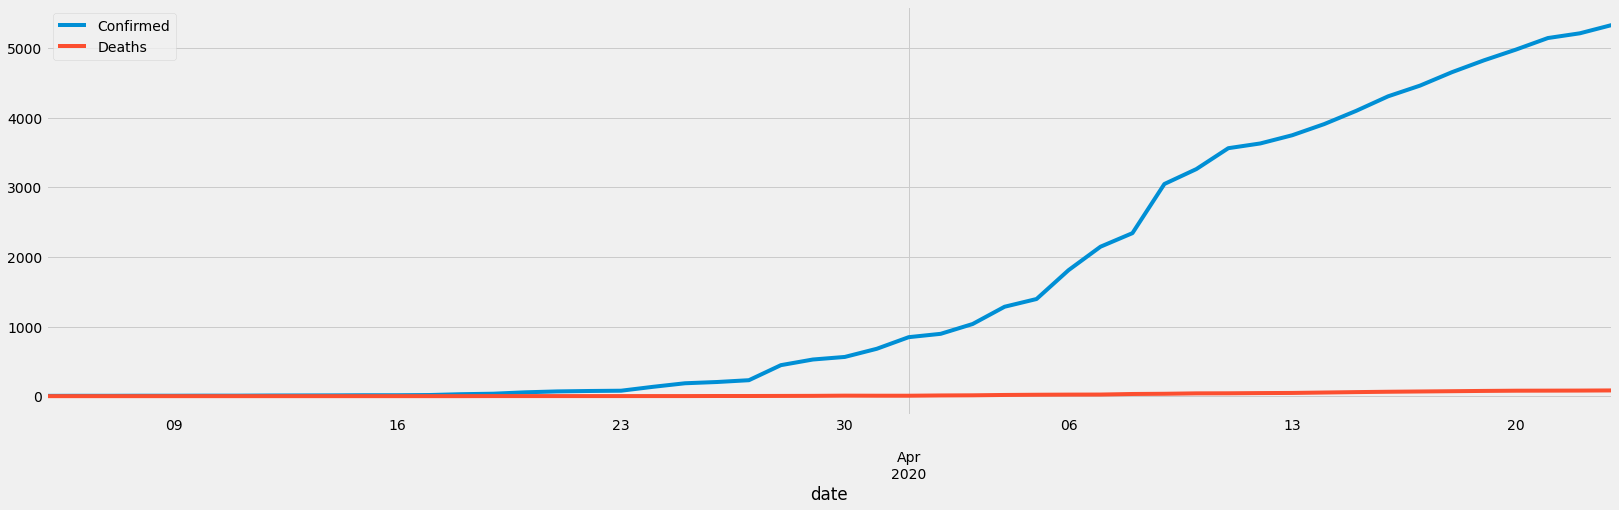

first row date 2020-03-05 00:00:00
total days 50 days, 0:00:00
split_date 2020-04-14
Train Data Description

         Confirmed
count    41.000000
mean    885.853659
std    1263.585030
min       4.000000
25%      13.000000
50%     185.000000
75%    1284.000000
max    3907.000000

Train Test Split Trend


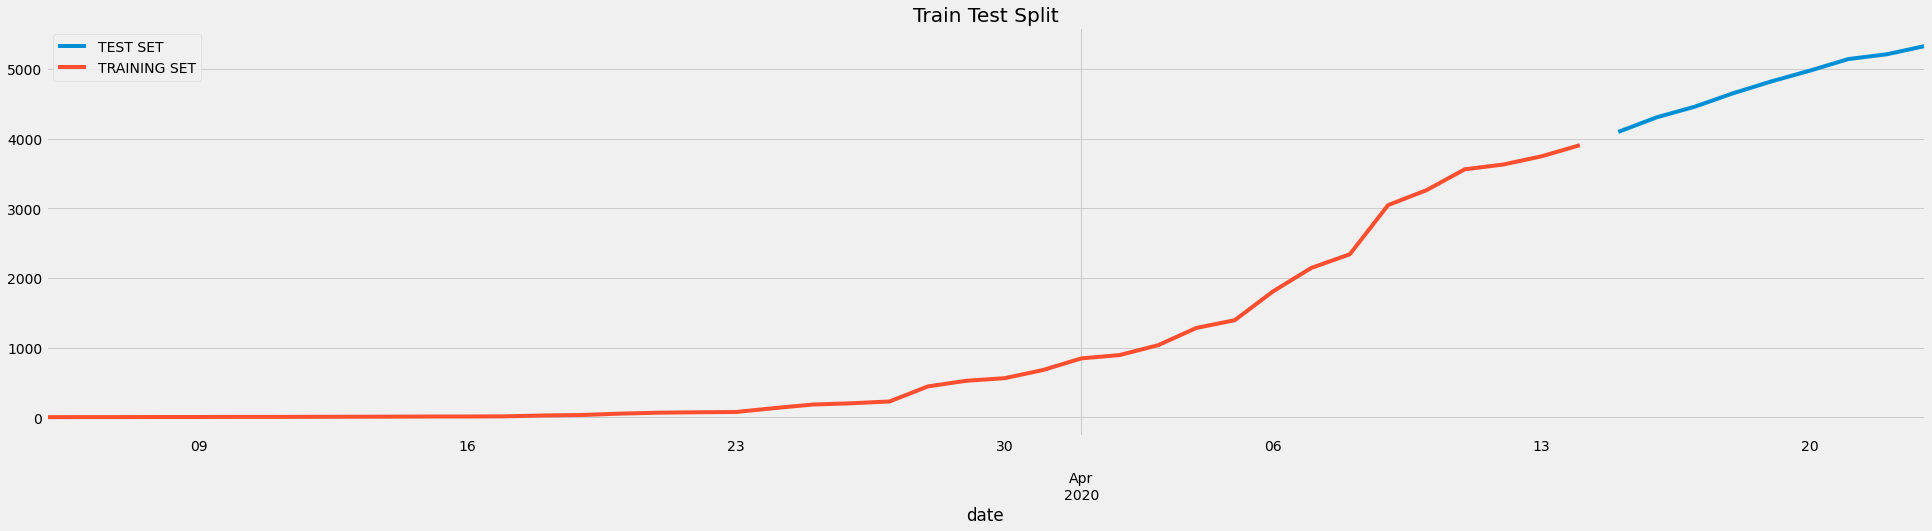

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Formatting data for fbprophet model

          ds  y
0 2020-03-05  4
1 2020-03-06  5
2 2020-03-07  5
3 2020-03-08  6
4 2020-03-09  6
Test Set Prediction Values and thresholds

          ds        trend  ...  multiplicative_terms_upper         yhat
0 2020-04-15  2664.401314  ...                         0.0  3039.189680
1 2020-04-16  2757.558618  ...                         0.0  3075.335547
2 2020-04-17  2850.715922  ...                         0.0  2896.675319
3 2020-04-18  2943.873226  ...                         0.0  2865.258678
4 2020-04-19  3037.030530  ...                         0.0  2734.880388

[5 rows x 19 columns]

Test Set Prediction Trend



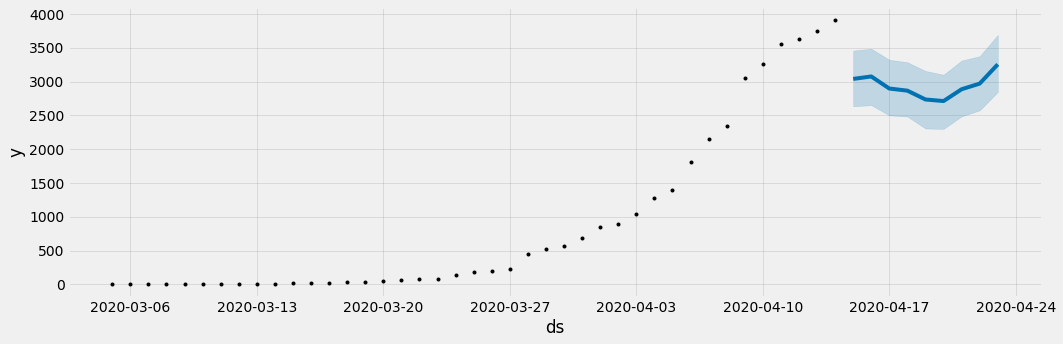


Test Set components Trend



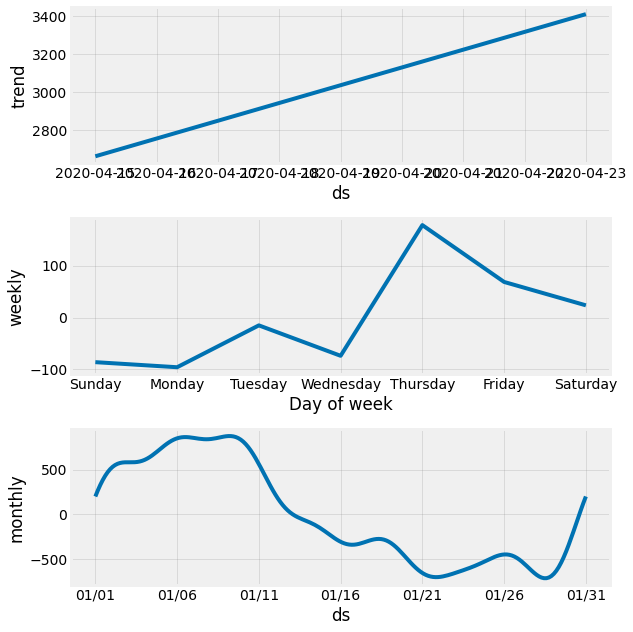

Forecast for next two weeks



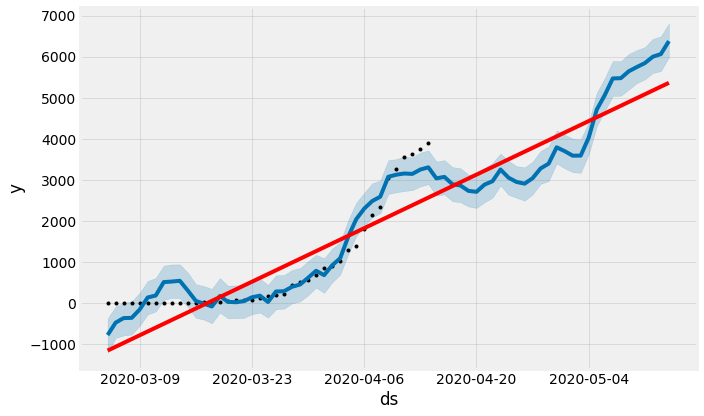

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-08 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-08 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-08 00:00:00 and 2020-04-13 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True

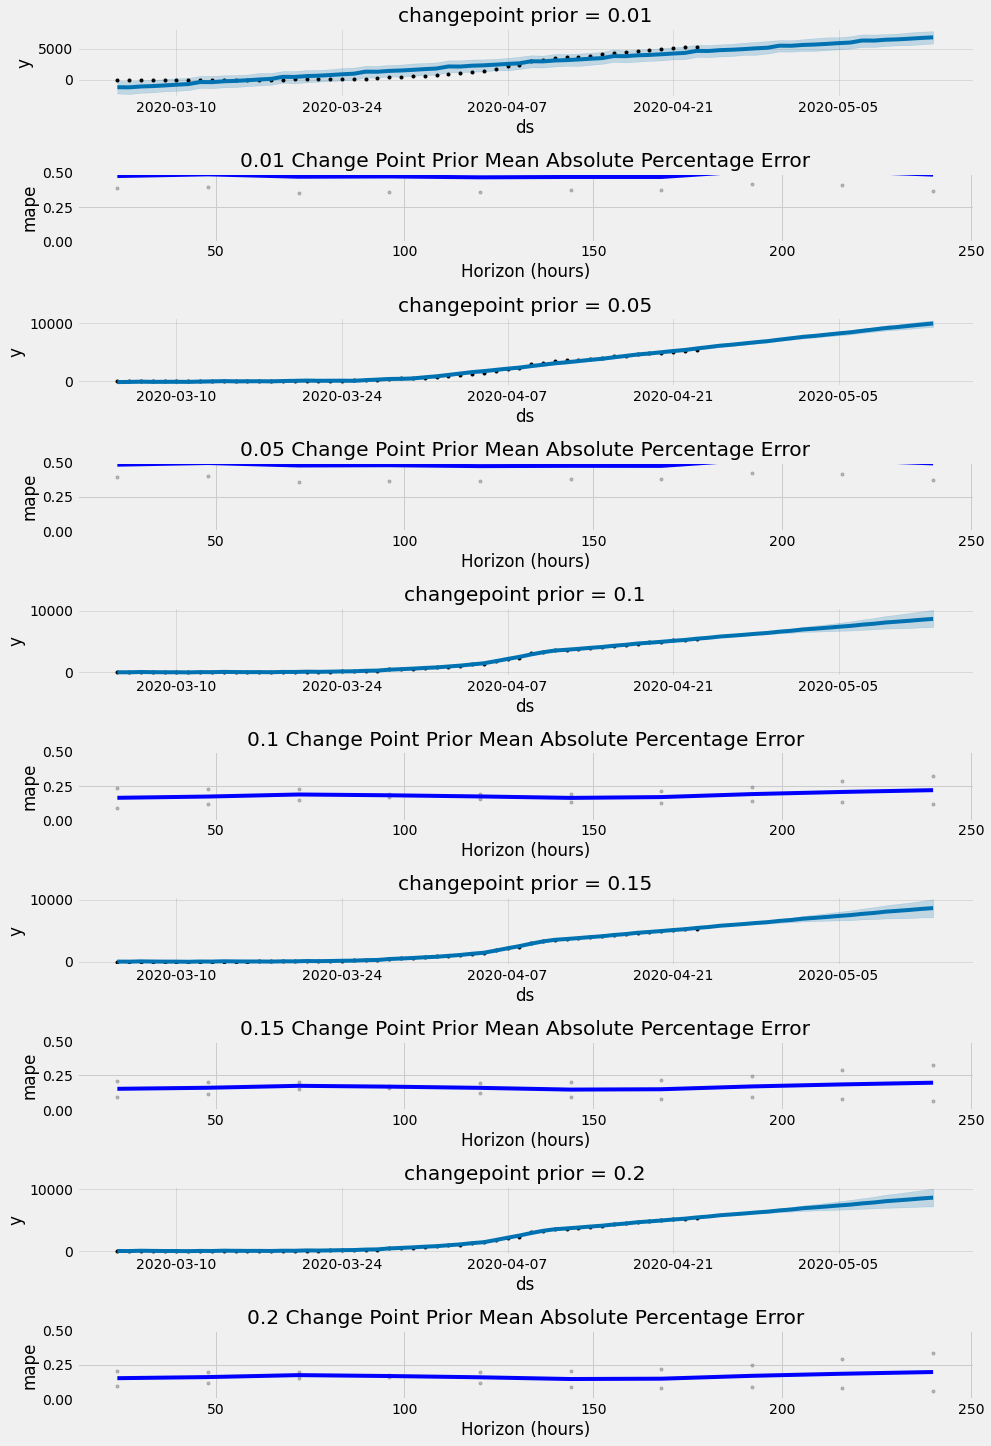

Performance and Error Metrics

  horizon            mse        rmse         mae      mape     mdape  coverage
0  1 days  273073.480895  522.564332  508.252332  0.152833  0.152833       0.0
1  2 days  337069.103141  580.576527  575.360618  0.160865  0.160865       0.0
2  3 days  463395.289661  680.731437  680.300982  0.175104  0.175104       0.0
3  4 days  480246.491442  692.998190  684.918165  0.168443  0.168443       0.0
4  5 days  525870.388032  725.169213  686.663573  0.159358  0.159358       0.0


In [0]:
predictSpread("Texas","Harris")

Data Description

            Confirmed  Deaths
date                         
2020-04-19          1       0
2020-04-20          1       0
2020-04-21          1       0
2020-04-22          1       0
2020-04-23          4       0

 Current Spread Trend in the Houston county,  Texas


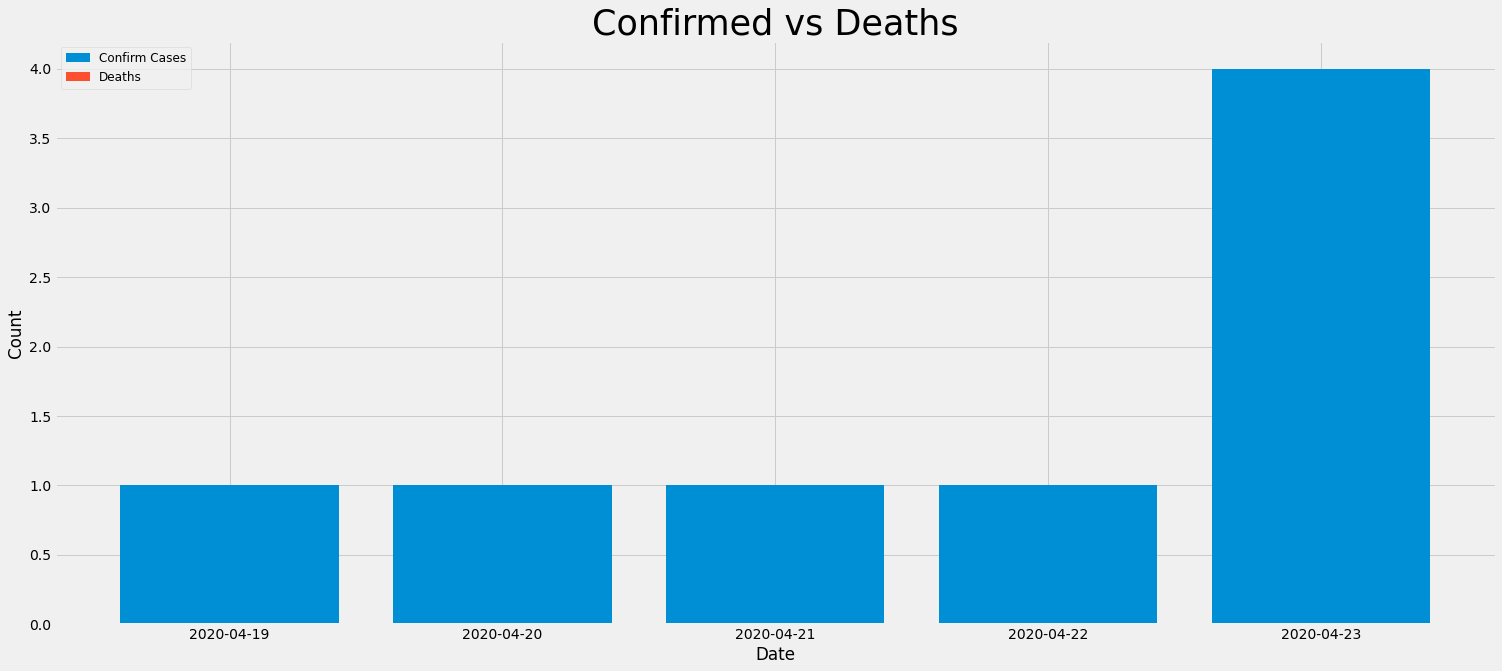

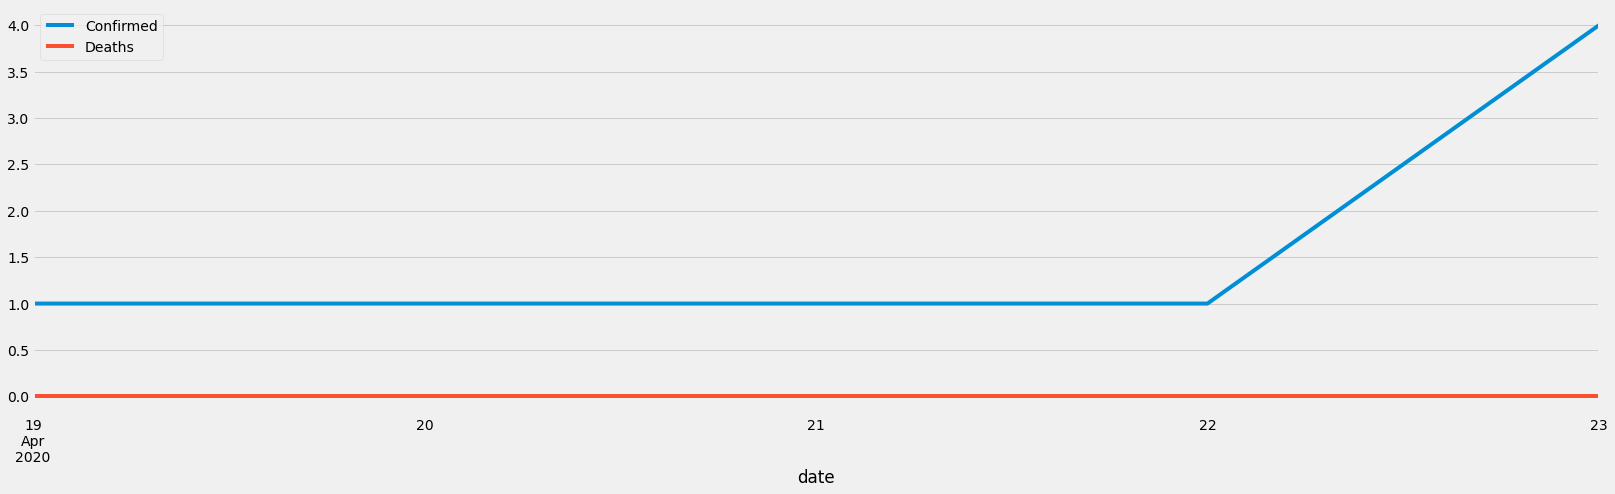

 Too less data to forsee the forecast or The  Houston  County is very good at Social Distancing 


In [0]:
predictSpread("Texas","Houston")